
VISUAL SALIENCY DETECTION


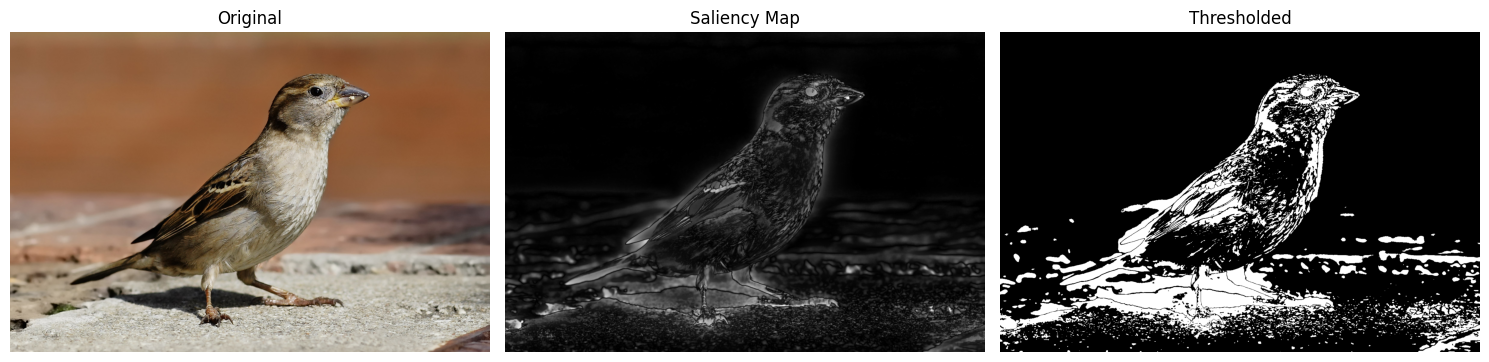


K-MEANS SEGMENTATION (k=4)


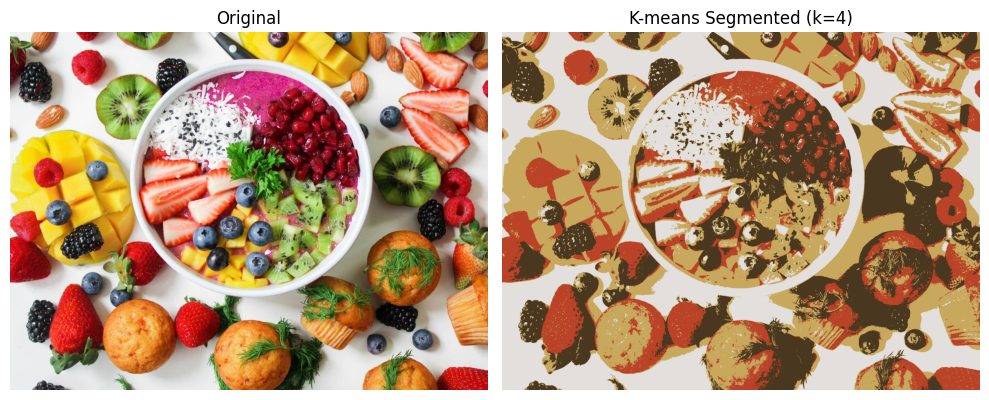


GRABCUT SEGMENTATION


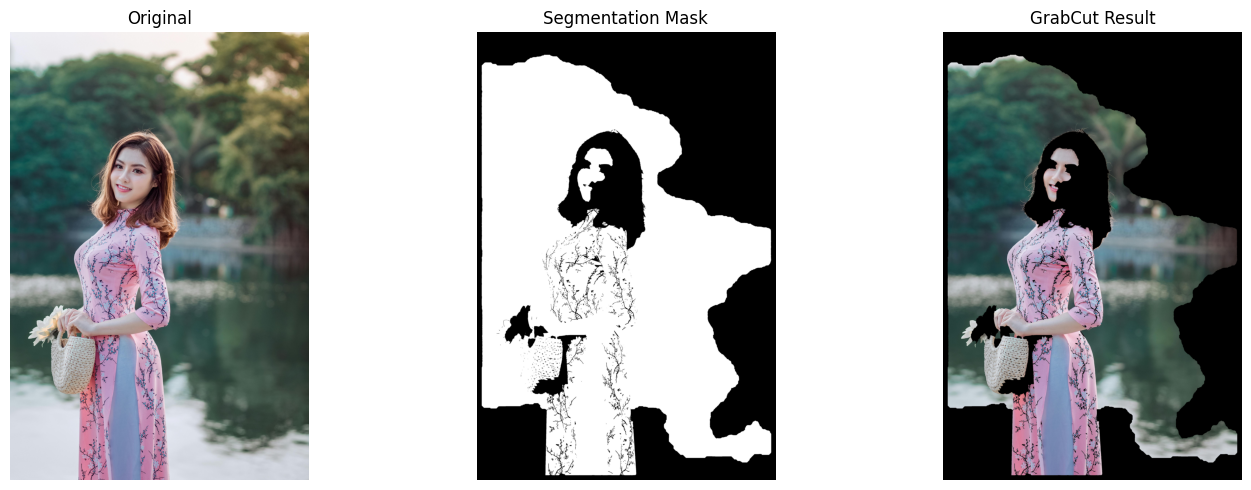


All tasks completed successfully!


In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import os

class ImageProcessor:
    """A class to handle all image processing tasks"""

    def __init__(self):

        self.image_paths = {
            'saliency': 'House_sparrow04.jpg',
            'kmeans': 'pexels-photo-1092730.jpeg',
            'grabcut': 'pexels-photo-1468379.jpeg'
        }
        self.validate_image_paths()

    def validate_image_paths(self):
        """Check if all image paths exist"""
        for task, path in self.image_paths.items():
            if not os.path.exists(path):
                raise FileNotFoundError(f"Image for {task} not found at {path}")

    def run_all_tasks(self):
        """Run all three processing tasks sequentially"""
        self.run_saliency_detection()
        self.run_kmeans_segmentation()
        self.run_grabcut_segmentation()
        print("\nAll tasks completed successfully!")

    def run_saliency_detection(self):
        """Run and visualize saliency detection"""
        print("\n" + "="*50)
        print("VISUAL SALIENCY DETECTION")
        print("="*50)

        image = self._load_image(self.image_paths['saliency'])
        if image is None:
            return


        saliency = cv2.saliency.StaticSaliencyFineGrained_create()
        success, saliency_map = saliency.computeSaliency(image)

        if not success:
            print("Failed to compute saliency map")
            return

        saliency_map = (saliency_map * 255).astype("uint8")
        _, thresh_map = cv2.threshold(saliency_map, 0, 255,
                                    cv2.THRESH_BINARY | cv2.THRESH_OTSU)


        self._plot_comparison(
            image,
            [saliency_map, thresh_map],
            ["Saliency Map", "Thresholded"],
            cmap='gray'
        )

    def run_kmeans_segmentation(self, k=4):
        """Run and visualize K-means segmentation"""
        print("\n" + "="*50)
        print(f"K-MEANS SEGMENTATION (k={k})")
        print("="*50)

        image = self._load_image(self.image_paths['kmeans'])
        if image is None:
            return


        processed = self._kmeans_process(image, k)


        self._plot_comparison(
            image,
            [processed],
            [f"K-means Segmented (k={k})"]
        )

    def run_grabcut_segmentation(self):
        """Run and visualize GrabCut segmentation"""
        print("\n" + "="*50)
        print("GRABCUT SEGMENTATION")
        print("="*50)

        image = self._load_image(self.image_paths['grabcut'])
        if image is None:
            return


        mask, result = self._grabcut_process(image)


        self._plot_comparison(
            image,
            [mask, result],
            ["Segmentation Mask", "GrabCut Result"],
            cmap='gray'
        )

    def _load_image(self, path):
        """Helper to load and convert image"""
        image = cv2.imread(path)
        if image is None:
            print(f"Error: Could not read image at {path}")
            return None
        return cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    def _kmeans_process(self, image, k):
        """Perform K-means clustering"""
        pixel_values = image.reshape((-1, 3))
        pixel_values = np.float32(pixel_values)

        criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.2)
        _, labels, centers = cv2.kmeans(pixel_values, k, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)

        centers = np.uint8(centers)
        return centers[labels.flatten()].reshape(image.shape)

    def _grabcut_process(self, image):
        """Perform GrabCut segmentation"""
        img_bgr = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
        mask = np.zeros(img_bgr.shape[:2], np.uint8)


        h, w = img_bgr.shape[:2]
        rect = (50, 50, w-100, h-100)


        bgd_model = np.zeros((1, 65), np.float64)
        fgd_model = np.zeros((1, 65), np.float64)


        cv2.grabCut(img_bgr, mask, rect, bgd_model, fgd_model, 5, cv2.GC_INIT_WITH_RECT)


        final_mask = np.where((mask == 2) | (mask == 0), 0, 1).astype('uint8')
        result = image * final_mask[:, :, np.newaxis]

        return final_mask, result

    def _plot_comparison(self, original, processed_list, titles_list, cmap=None):
        """Helper to plot original vs processed images"""
        num_images = 1 + len(processed_list)
        plt.figure(figsize=(5*num_images, 5))


        plt.subplot(1, num_images, 1)
        plt.imshow(original)
        plt.title("Original")
        plt.axis('off')


        for i, (processed, title) in enumerate(zip(processed_list, titles_list), 2):
            plt.subplot(1, num_images, i)
            if cmap:
                plt.imshow(processed, cmap=cmap)
            else:
                plt.imshow(processed)
            plt.title(title)
            plt.axis('off')

        plt.tight_layout()
        plt.show()


if __name__ == "__main__":
    processor = ImageProcessor()
    processor.run_all_tasks()